In [1]:
import spektral
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

seed_value = 42

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
dataset = spektral.datasets.citation.Citation(
    'cora', 
    random_split=True,
    normalize_x=False,
    dtype=np.float32
    )

from  sklearn.model_selection  import  train_test_split

X = dataset[0].x
y = dataset[0].y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f'Training: X {X_train.shape}, y {y_train.shape}, {X_train.shape[0]} nodes')
print(f'Validation: X {X_validation.shape}, y {y_validation.shape},  {X_validation.shape[0]} nodes')
print(f'Test: X {X_test.shape}, y {y_test.shape}, {X_test.shape[0]} nodes')


Training: X (1516, 1433), y (1516, 7), 1516 nodes
Validation: X (379, 1433), y (379, 7),  379 nodes
Test: X (813, 1433), y (813, 7), 813 nodes


/Users/ghostmou/virtualenvs/uoc-tfg-gnn/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [25]:
def get_reduced_data(original_data, clusters):
    from sklearn import cluster

    X_reduced_agglo = cluster.FeatureAgglomeration(n_clusters=clusters)
    X_reduced_agglo.fit(original_data)
    X_reduced = X_reduced_agglo.transform(X)

    return X_reduced

def split_data(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42, stratify=y)
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


def create_model(X_train, y_train, X_validation, y_validation):
    # IMPORTANT!!!!
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    random.seed(seed_value)

    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    sequential_model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=X_train[0].shape, name='nodes_input'),
        keras.layers.Dense(100, activation=keras.activations.relu, name='hidden_dense'),
        keras.layers.Dense(7, activation=keras.activations.relu, name='output')
    ])

    sequential_model.compile(
        optimizer=Adam(),
        loss=CategoricalCrossentropy(reduction='sum'), # Loss function to be used.
        weighted_metrics=['acc']
    )

    sequential_model_history = sequential_model.fit(
        X_train, y_train, epochs=30, 
        validation_data=(X_validation, y_validation),
        callbacks=[
            EarlyStopping(patience=20,  restore_best_weights=True, monitor='val_loss', mode='min'), # Early stopping callback
        ], 
        verbose=0
    )

    return sequential_model, sequential_model_history

In [53]:
def evaluate_model(sequential_model, X_train, y_train, X_validation, y_validation, X_test, y_test):
    results_over_test = sequential_model.evaluate(X_test, y_test, batch_size=42, verbose=-1)
    results_over_training = sequential_model.evaluate(X_train, y_train, batch_size=42, verbose=-1)
    results_over_validation = sequential_model.evaluate(X_validation, y_validation, batch_size=42, verbose=-1)
    
    return results_over_training, results_over_validation, results_over_test

In [54]:
# Original data
model_original_data, model_original_data_history = create_model(X_train, y_train, X_validation, y_validation)
results_over_training, results_over_validation, results_over_test = evaluate_model(model_original_data, X_train, y_train, X_validation, y_validation, X_test, y_test)

print(f'With original data ({X_train.shape[1]} features)')
print(f'Evaluation over training data: ')
print(f'\tLoss: {results_over_training[0]}')
print(f'\tAccuracy: {results_over_training[1]*100:.2f}%')

print(f'Evaluation over validation data: ')
print(f'\tLoss: {results_over_validation[0]}')
print(f'\tAccuracy: {results_over_validation[1]*100:.2f}%')

print(f'Evaluation over test data: ')
print(f'\tLoss: {results_over_test[0]}')
print(f'\tAccuracy: {results_over_test[1]*100:.2f}%')

With original data (1433 features)
Evaluation over training data: 
	Loss: 73.60014343261719
	Accuracy: 68.47%
Evaluation over validation data: 
	Loss: 81.18524932861328
	Accuracy: 50.40%
Evaluation over test data: 
	Loss: 73.11640167236328
	Accuracy: 54.49%


In [67]:
# Reduced data
def get_results_reduced_data(X, clusters):
    reduced_data = get_reduced_data(X, clusters)
    return split_data(reduced_data, y)


results = []
for n_clusters in range(200, X_train.shape[1]):
    X_train_reduced, y_train_reduced, X_validation_reduced, y_validation_reduced, X_test_reduced, y_test_reduced = get_results_reduced_data(X, n_clusters)
    model_reduced_data, model_reduced_data_history = create_model(X_train_reduced, y_train_reduced, X_validation_reduced, y_validation_reduced)
    results_over_training, results_over_validation, results_over_test = evaluate_model(
        model_reduced_data, X_train_reduced, y_train_reduced, X_validation_reduced, y_validation_reduced, X_test_reduced, y_test_reduced)
    
    sub_result = {
        'n_clusters': n_clusters,
        'training_accuracy': results_over_training[1], 'training_loss': results_over_training[0],
        'validation_accuracy': results_over_validation[1], 'validation_loss': results_over_validation[0],
        'test_accuracy': results_over_test[1], 'test_loss': results_over_test[0]
    }
    results.append(sub_result)
    print(sub_result)

#print(f'\n\nWith new data ({X_train_reduced.shape[1]} features)')
print(results)



{'n_clusters': 200, 'training_accuracy': 0.5323218703269958, 'training_loss': 64.2953109741211, 'validation_accuracy': 0.4511873424053192, 'validation_loss': 78.83323669433594, 'test_accuracy': 0.4575645625591278, 'test_loss': 78.97384643554688}
{'n_clusters': 201, 'training_accuracy': 0.4755936563014984, 'training_loss': 77.11286926269531, 'validation_accuracy': 0.3931398391723633, 'validation_loss': 80.64633178710938, 'test_accuracy': 0.4132841229438782, 'test_loss': 80.33720397949219}
{'n_clusters': 202, 'training_accuracy': 0.5316622853279114, 'training_loss': 67.44438171386719, 'validation_accuracy': 0.4432717561721802, 'validation_loss': 80.76496887207031, 'test_accuracy': 0.47847479581832886, 'test_loss': 80.49151611328125}
{'n_clusters': 203, 'training_accuracy': 0.5712401270866394, 'training_loss': 62.74747085571289, 'validation_accuracy': 0.47757256031036377, 'validation_loss': 76.42350769042969, 'test_accuracy': 0.5043050646781921, 'test_loss': 79.33672332763672}
{'n_cluster

In [68]:
import pandas as pd
df = pd.DataFrame(results)

,n_clusters,training_accuracy,training_loss,validation_accuracy,validation_loss,test_accuracy,test_loss
0,200,0.532322,64.295311,0.451187,78.833237,0.457565,78.973846
1,201,0.475594,77.112869,0.393140,80.646332,0.413284,80.337204
2,202,0.531662,67.444382,0.443272,80.764969,0.478475,80.491516
3,203,0.571240,62.747471,0.477573,76.423508,0.504305,79.336723
4,204,0.468338,82.955284,0.390501,86.561623,0.393604,87.215599


In [93]:
df.sort_values('test_accuracy', ascending=False).head()

,n_clusters,training_accuracy,training_loss,validation_accuracy,validation_loss,test_accuracy,test_loss
795,995,0.838391,50.793472,0.641161,79.108208,0.660517,58.591331
723,923,0.843008,43.292603,0.606860,70.335869,0.659287,63.246941
822,1022,0.841689,46.404930,0.617414,68.419960,0.656827,70.686317
542,742,0.813325,49.259415,0.625330,80.879120,0.654367,69.774422
804,1004,0.844327,46.056202,0.622691,72.095871,0.653137,65.542480


In [99]:
df[df['n_clusters'].isin([732, 995, 1242])].sort_values('n_clusters', ascending=True).reset_index().head()

,index,n_clusters,training_accuracy,training_loss,validation_accuracy,validation_loss,test_accuracy,test_loss
0,532,732,0.777045,50.610359,0.641161,70.317093,0.621156,64.563782
1,795,995,0.838391,50.793472,0.641161,79.108208,0.660517,58.591331
2,1042,1242,0.862797,NaN,0.635884,63.104225,0.653137,64.179420


Classification report
                        precision    recall  f1-score   support

            Case_Based       0.47      0.63      0.54       105
    Genetic_Algorithms       0.66      0.51      0.57        65
       Neural_Networks       0.78      0.67      0.72       126
 Probabilistic_Methods       0.71      0.78      0.75       246
Reinforcement_Learning       0.67      0.65      0.66       128
         Rule_Learning       0.66      0.58      0.62        89
                Theory       0.60      0.50      0.55        54

              accuracy                           0.66       813
             macro avg       0.65      0.62      0.63       813
          weighted avg       0.67      0.66      0.66       813



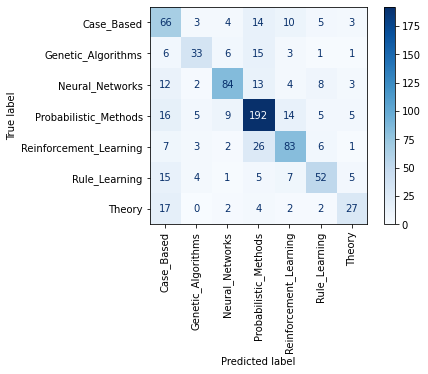

In [78]:
label_names = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 
    'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']

X_train_reduced, y_train_reduced, X_validation_reduced, y_validation_reduced, X_test_reduced, y_test_reduced = get_results_reduced_data(X, 995)
model_reduced_data, model_reduced_data_history = create_model(X_train_reduced, y_train_reduced, X_validation_reduced, y_validation_reduced)

# Get predictions for the test set
predictions = model_reduced_data.predict(X_test_reduced)
y_predictions_values = np.argmax(predictions, axis=1)
y_test_values = np.argmax(y_test_reduced, axis=1)

from sklearn.metrics import classification_report
report = classification_report(y_test_values, y_predictions_values, target_names=label_names)
print('Classification report')
print('=====================')
print(report)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_test_values, y_predictions_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')